In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [43]:
raw_dataset = pd.read_csv(os.path.join("data", "flight_data_processed.csv"))
raw_dataset["zone"] = raw_dataset["zone"].apply(lambda x: True if x == "thermal" else False)
raw_dataset = raw_dataset[["gps_altitude_m","speed_km/s","climb_m","climb_m(delta)","climb_rate_m/s","bearing","delta_bearing","glide_ratio","elapsed_time","temp","pressure","humidity","dew_point","wind_speed","wind_deg", "zone"]]
dataset = raw_dataset.copy()
dataset.head()

/var/folders/ss/5qhyykzn7ws047pz5bmmgw1r0000gn/T/ipykernel_5688/2147613681.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_dataset = pd.read_csv(os.path.join("data", "flight_data_processed.csv"))


,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg,zone
0,1115,12.218615,0.0,-3.0,0.0,303,67.0,0.000000,0.0,26.69,1010.0,37.0,10.81,3.38,306.0,False
1,1115,25.606488,0.0,-3.0,0.0,270,33.0,0.000000,1.0,26.69,1010.0,37.0,10.81,3.38,306.0,False
2,1115,20.485190,0.0,-3.0,0.0,270,0.0,0.000000,2.0,26.69,1010.0,37.0,10.81,3.38,306.0,False
3,1116,25.606488,1.0,-2.0,1.0,270,0.0,7.112913,3.0,26.69,1010.0,37.0,10.81,3.38,306.0,True
4,1117,21.541278,1.0,-1.0,1.0,288,18.0,5.983688,4.0,26.69,1010.0,37.0,10.81,3.38,306.0,True


In [44]:
dataset.describe()

,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
count,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000
mean,2549.013677,52.049776,-0.031964,-0.632339,-0.026192,128.208505,11.336541,8.336186,16822.956221,31.048488,1006.838010,30.089995,10.966365,3.138136,229.898335
std,621.275795,25.169579,2.587599,44.476908,1.869562,93.148811,17.172823,8.480289,9743.969272,2.945894,2.086364,7.442854,2.804663,1.262021,100.911881
min,376.000000,0.000000,-30.000000,-383.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,24.160000,1003.000000,14.000000,3.190000,0.500000,0.000000
25%,2160.000000,41.296352,-1.000000,-26.000000,-1.000000,47.000000,2.000000,3.082997,8427.000000,28.920000,1005.000000,23.000000,9.700000,2.020000,202.000000
50%,2551.000000,53.539497,0.000000,-1.000000,0.000000,122.000000,6.000000,7.368595,16791.000000,30.610000,1007.000000,33.000000,11.250000,3.370000,234.000000
75%,2937.000000,63.605984,1.000000,23.000000,1.000000,184.000000,14.000000,12.795062,25154.000000,33.810000,1008.000000,36.000000,13.010000,4.220000,316.000000
max,4403.000000,4788.987450,44.000000,1222.000000,44.000000,358.000000,180.000000,1306.481640,36656.000000,37.130000,1015.000000,42.000000,17.500000,5.510000,358.000000


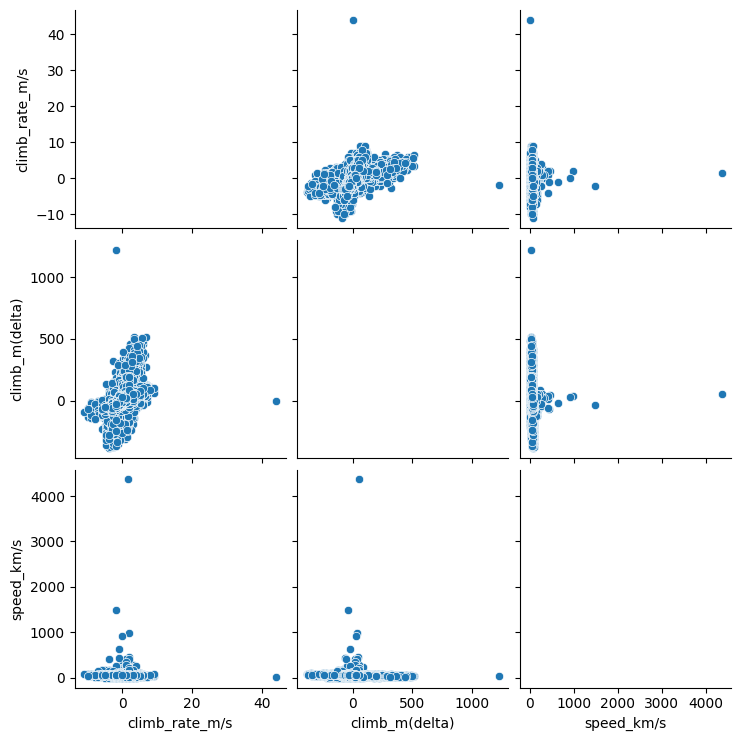

In [45]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["climb_rate_m/s", "climb_m(delta)", "speed_km/s"]], diag_kind="zone")

Let's also check the overall statistics. Note how each feature covers a very different range:

In [46]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gps_altitude_m,139154.0,2548.626780,621.342319,376.00,2160.000000,2551.000000,2937.000000,4403.000000
speed_km/s,139154.0,51.973147,21.246772,0.00,41.289233,53.539357,63.600100,4361.850992
climb_m,139154.0,-0.034271,2.580568,-30.00,-1.000000,0.000000,1.000000,44.000000
climb_m(delta),139154.0,-0.638868,44.534428,-383.00,-26.000000,-1.000000,23.000000,1222.000000
climb_rate_m/s,139154.0,-0.025410,1.870311,-11.00,-1.000000,0.000000,1.000000,44.000000
bearing,139154.0,128.165859,93.077509,0.00,47.000000,122.000000,184.000000,358.000000
delta_bearing,139154.0,11.323893,17.113174,0.00,2.000000,6.000000,14.000000,180.000000
glide_ratio,139154.0,8.313781,7.821970,0.00,3.082997,7.353455,12.762419,807.750184
elapsed_time,139154.0,16836.620924,9751.289315,0.00,8417.000000,16821.500000,25155.000000,36656.000000
temp,139154.0,31.049846,2.948625,24.16,28.920000,30.610000,33.810000,37.130000


In [47]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("zone")
test_labels = test_features.pop("zone")

train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
gps_altitude_m,2548.626780,621.342319
speed_km/s,51.973147,21.246772
climb_m,-0.034271,2.580568
climb_m(delta),-0.638868,44.534428
climb_rate_m/s,-0.025410,1.870311
bearing,128.165859,93.077509
delta_bearing,11.323893,17.113174
glide_ratio,8.313781,7.821970
elapsed_time,16836.620924,9751.289315
temp,31.049846,2.948625


In [48]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 2548.627    51.973    -0.034    -0.639    -0.025   128.166    11.324
      8.314 16836.621    31.05   1006.836    30.078    10.96      3.139
    229.927]]


In [49]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 2300.      77.76    -3.     -41.      -3.     160.       0.       7.2
  12410.      29.88  1008.      41.      15.21     3.5    340.  ]]

Normalized: [[-0.4   1.21 -1.15 -0.91 -1.59  0.34 -0.66 -0.14 -0.45 -0.4   0.56  1.47
   1.51  0.29  1.09]]


In [50]:
vario = np.array(train_features["climb_rate_m/s"])

vario_normalizer = layers.Normalization(input_shape=[1,], axis=None)
vario_normalizer.adapt(vario)
vario_model = tf.keras.Sequential([
    vario_normalizer,
    layers.Dense(units=1)
])

vario_model.summary()

/Users/serkan/Documents/Paragliding_Flight_Analyses/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_7 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [51]:
vario_model.predict(vario[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[ 1.619],
       [ 0.53 ],
       [-2.191],
       [-3.279],
       [ 1.619],
       [-0.014],
       [ 1.075],
       [ 1.075],
       [-1.102],
       [ 1.619]], dtype=float32)

In [52]:
vario_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [54]:
%%time
history = vario_model.fit(
    train_features["climb_rate_m/s"],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

CPU times: user 2min 26s, sys: 23.2 s, total: 2min 49s
Wall time: 1min 57s


,loss,val_loss,epoch
95,0.287035,0.304230,95
96,0.287739,0.290786,96
97,0.286832,0.279629,97
98,0.286840,0.280989,98
99,0.287139,0.282436,99


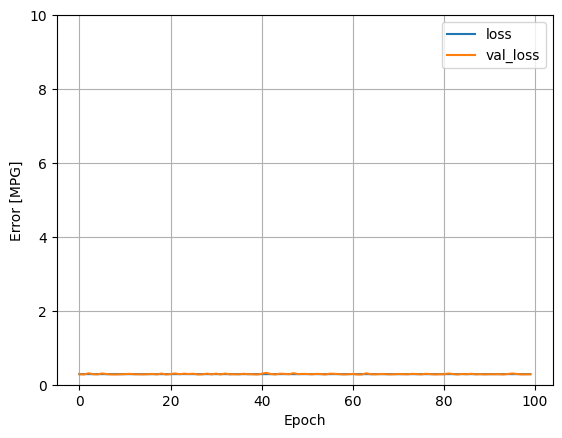

In [55]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  
plot_loss(history)

Collect the results on the test set for later:

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

In [ ]:
plot_horsepower(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $x$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [ ]:
linear_model.predict(train_features[:10])

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [ ]:
linear_model.layers[1].kernel

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

In [ ]:
plot_loss(history)

Collect the results on the test set for later:

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'Horsepower'` as input and `horsepower_normalizer` (defined earlier) as the normalization layer:

In [ ]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [ ]:
dnn_horsepower_model.summary()

Train the model with Keras `Model.fit`:

In [ ]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

This model does slightly better than the linear single-input `horsepower_model`:

In [ ]:
plot_loss(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

In [ ]:
plot_horsepower(x, y)

Collect the results on the test set for later:

In [ ]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [ ]:
plot_loss(history)

Collect the results on the test set:

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [ ]:
dnn_model.save('dnn_model.keras')

If you reload the model, it gives identical output:

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.